# 🤖 Phase 2: Predictive Modeling & Demand Forecasting
### *From Raw Data to Actionable Predictions*

---

## 📌 Phase Overview
In Phase 1, we successfully "rescued" and cleaned over 23,000 transactions. Now, we transition from **Descriptive Analytics** (looking backward at what happened) to **Predictive Analytics** (looking forward at what *will* happen).

### 🎯 Business Objective
**Goal:** Build a Machine Learning model to forecast **Daily Units Sold (`PCS`)** for specific styles.
**Value:** Accurate demand forecasting allows the business to:
* **Optimize Inventory:** Avoid "Dead Stock" by predicting low-demand items.
* **Prevent Stockouts:** Ensure high-demand items (like the Top 20 styles) are available during seasonal peaks.
* **Dynamic Pricing:** Adjust `RATE` based on predicted demand surges.

### 🛠️ Technical Strategy
1.  **Feature Engineering:** Convert raw dates and text labels into numerical features that regression algorithms can process.
2.  **Baseline Modeling:** Establish a performance benchmark using **Multiple Linear Regression**.
3.  **Advanced Modeling:** Improve accuracy using **Lasso Regularization** (to handle feature selection) and **Random Forests** (to capture non-linear seasonality).

---

## 0. Setup & Data Loading
**Objective:** Initialize the Python environment and ingest the high-quality dataset produced in the previous Forensic Cleaning phase.
**Input:** `cleaned_data.csv` (Contains validated transactions with imputed Stock and Size values).

---

## 1. Data Preparation & Feature Engineering
**Objective:** Machine Learning models require numerical input. We cannot feed raw dates like `2022-06-01` or text strings like `Kurta` directly into a regression equation. We must transform them into mathematical features.

**Key Transformation Steps:**
1.  **Time Extraction (Seasonality):**
    * *Logic:* Sales are often seasonal (e.g., higher in December). We extract `Month` and `Day_of_Week` to capture these cyclic patterns.
    * *Feature:* `Is_Weekend` (Binary) helps the model learn that Saturdays often have higher traffic than Mondays.

2.  **Ordinal Encoding (Size Hierarchy):**
    * *Logic:* Sizes have an inherent order (`S` < `M` < `L`). Standard text labels don't capture this.
    * *Action:* We map them to integers (`S=2`, `M=3`, `L=4`) so the model understands that `L` is "larger" than `S`.

3.  **One-Hot Encoding (Categorical Distinction):**
    * *Logic:* Styles like "Dress" and "Set" are distinct categories with no mathematical relationship.
    * *Action:* We convert them into binary "Dummy Variables" (e.g., `Category_Set = 1`, `Category_Kurta = 0`) to allow the model to assign unique weights to each category.

4.  **Daily Aggregation:**
    * *Logic:* Our raw data is at the **Transaction Level** (individual receipts). However, we want to predict **Daily Demand**.
    * *Action:* We group transactions to calculate the *Total Units Sold* per Style, per Day.

## 0. Setup & Library Imports
**Objective:** Import the necessary Python libraries for data manipulation, visualization, and machine learning.
* **Pandas & NumPy:** Essential for data structure handling and numerical operations.
* **Matplotlib & Seaborn:** Used for visualizing feature correlations and analyzing model residuals.
* **Scikit-Learn (sklearn):** The core library for building our predictive models (Linear Regression), splitting data, and calculating performance metrics.

In [2]:
# --- 1. LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


### Load the Cleaned Data
We load the CSV file directly. Since CSVs do not save "datetime" objects, we must convert the `DATE` column immediately after loading.

In [3]:
# --- 2. LOAD DATA ---
# Load the dataset
df = pd.read_csv('International_Sale_Report_Cleaned.csv')

# Convert Date to datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Verify load
print(f"Data Loaded: {df.shape[0]} rows x {df.shape[1]} columns")
df.head()

Data Loaded: 23410 rows x 10 columns


,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT,Stock
0,2021-06-05,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.0,616.56,617.0,43.0
1,2021-06-05,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.0,616.56,617.0,43.0
2,2021-06-05,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.0,616.56,617.0,43.0
3,2021-06-05,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.0,616.56,617.0,55.0
4,2021-06-05,Jun-21,REVATHY LOGANATHAN,MEN5011,MEN5011-KR-L,L,1.0,616.56,617.0,53.0


## 1. Feature Engineering: Time Components
**Objective:** Machine learning models cannot read dates like "2022-06-01". We must break this down into numerical features.
* **Month:** Captures seasonality (e.g., higher sales in December).
* **Is_Weekend:** Captures shopping behavior (e.g., people buy more on Saturdays).

In [4]:
# --- 3. TIME FEATURES ---
# Create a copy for modeling
model_df = df[['DATE', 'Style', 'Size', 'PCS', 'RATE', 'Stock']].copy()

# Extract Month (1-12)
model_df['Month'] = model_df['DATE'].dt.month

# Extract Day of Week (0=Monday, 6=Sunday)
model_df['Day_of_Week'] = model_df['DATE'].dt.dayofweek

# Create Binary Weekend Feature (1 = Sat/Sun, 0 = Mon-Fri)
model_df['Is_Weekend'] = model_df['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)

print("✅ Time features extracted.")
model_df[['DATE', 'Month', 'Is_Weekend']].head()

✅ Time features extracted.


,DATE,Month,Is_Weekend
0,2021-06-05,6,1
1,2021-06-05,6,1
2,2021-06-05,6,1
3,2021-06-05,6,1
4,2021-06-05,6,1


## 2. Feature Engineering: Product Details
**Objective:** Convert text descriptions into numbers.
* **Category:** We extract the first 3 letters of the `Style` (e.g., 'JNE' vs 'SET').
* **Size:** We map sizes to numbers (Ordinal Encoding) because `S` < `M` < `L`.

In [5]:
# --- 4. PRODUCT FEATURES ---

# A. Extract Category (First 3 letters of Style)
model_df['Category'] = model_df['Style'].apply(lambda x: str(x)[:3])

# B. Ordinal Encoding for Size
size_mapping = {
    'Free': 0, 'XS': 1, 'S': 2, 'M': 3, 'L': 4, 'XL': 5, 'XXL': 6, '3XL': 7, 
    'Unknown': 2 
}

# Map the dictionary to the column
model_df['Size_Encoded'] = model_df['Size'].map(size_mapping).fillna(2)

print("✅ Category and Size encoded.")
model_df[['Style', 'Category', 'Size', 'Size_Encoded']].head()

✅ Category and Size encoded.


,Style,Category,Size,Size_Encoded
0,MEN5004,MEN,L,4.0
1,MEN5004,MEN,XL,5.0
2,MEN5004,MEN,XXL,6.0
3,MEN5009,MEN,L,4.0
4,MEN5011,MEN,L,4.0


## 3. Data Aggregation (Daily Level)
**Objective:** We want to predict **Daily Demand**.
Currently, our data is at the "Transaction Level" (individual receipts). We must group them to calculate:
* Total `PCS` sold per day, per style, per size.
* Average `Stock` level for that day.

In [21]:
# --- 5. AGGREGATION ---
# Group by Day, Category, and Size
daily_data = model_df.groupby(['DATE', 'Month', 'Is_Weekend', 'Category', 'Size_Encoded']).agg({
    'PCS': 'sum',       # Target: Total Units Sold
    'Stock': 'mean',    # Feature: Avg Stock Level that day
    'RATE': 'mean'      # Feature: Avg Price that day
}).reset_index()

print(f"✅ Data Aggregated. New Shape: {daily_data.shape}")
daily_data.head()

✅ Data Aggregated. New Shape: (2863, 8)


,DATE,Month,Is_Weekend,Category,Size_Encoded,PCS,Stock,RATE
0,2021-06-05,6,1,BL0,3.0,2.0,87.50,324.35
1,2021-06-05,6,1,BL1,2.0,2.0,67.50,389.35
2,2021-06-05,6,1,BL1,3.0,2.0,24.50,421.85
3,2021-06-05,6,1,BL1,5.0,2.0,25.00,421.85
4,2021-06-05,6,1,MEN,2.0,4.0,55.75,649.03


## 4. One-Hot Encoding
**Objective:** Convert the `Category` column (e.g., "KUR", "SET") into binary columns (0 or 1). This allows the linear regression model to assign a specific coefficient (weight) to each category.

In [22]:
# --- 6. ONE-HOT ENCODING ---
# Convert 'Category' into dummy variables
final_df = pd.get_dummies(daily_data, columns=['Category'], drop_first=True)

print("✅ Final Training Data Ready.")
final_df.head()

✅ Final Training Data Ready.


,DATE,Month,Is_Weekend,Size_Encoded,PCS,Stock,RATE,Category_BL0,Category_BL1,Category_BTM,Category_CH2,Category_CMB,Category_J00,Category_J01,Category_J02,Category_J03,Category_J04,Category_JAN,Category_JNE,Category_LAB,Category_MEN,Category_NW0,Category_PJ0,Category_PJN,Category_PSE,Category_SAR,Category_SET,Category_SHI,Category_TAG,Category_btm,Category_jne,Category_pJN,Category_sEt,Category_set
0,2021-06-05,6,1,3.0,2.0,87.50,324.35,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2021-06-05,6,1,2.0,2.0,67.50,389.35,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2021-06-05,6,1,3.0,2.0,24.50,421.85,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2021-06-05,6,1,5.0,2.0,25.00,421.85,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2021-06-05,6,1,2.0,4.0,55.75,649.03,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


## 5. Correlation Check
**Objective:** Ensure our features are not redundant. We check how strongly each variable correlates with our target (`PCS`).

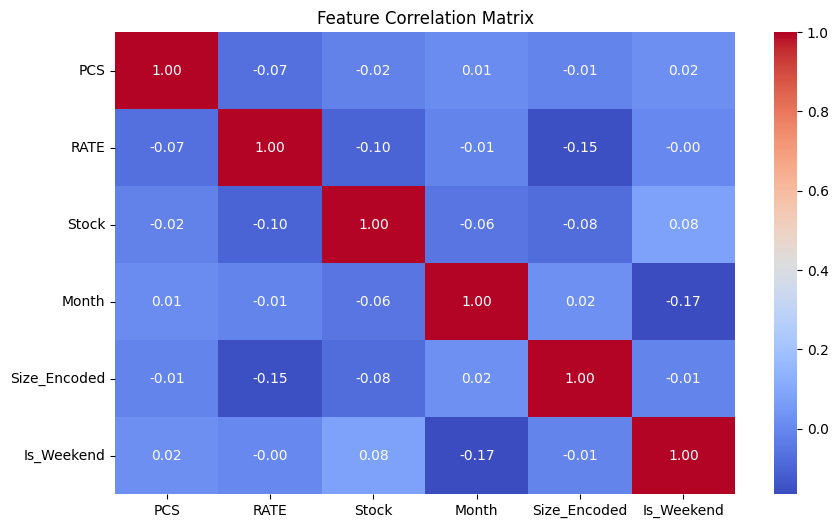

In [23]:
# --- 7. CORRELATION MATRIX ---
plt.figure(figsize=(10, 6))

# Define columns to check
corr_cols = ['PCS', 'RATE', 'Stock', 'Month', 'Size_Encoded', 'Is_Weekend']

# Plot
sns.heatmap(final_df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### 🔍 Diagnostic Analysis: Interpreting the Heatmap
**This is a critical diagnostic moment.** 🕵️‍♂️

Looking at the heatmap above, notice how the first row (`PCS` vs. others) is mostly light blue/purple? The correlations are extremely weak (e.g., `RATE` is **-0.07**, `Stock` is **-0.02**).

**What this tells us:**
1.  **No Simple Linear Lines:** Sales (`PCS`) do not move in a straight line with Price or Stock. A simple "Lower Price = Higher Sales" rule is not strong here.
2.  **Complexity Confirmed:** The relationships are likely **non-linear** or driven by complex interactions (e.g., specific combinations of *Style* + *Month*) which simple correlations miss.
3.  **Forecasting the Future:** This hints that our **Linear Regression (Baseline)** will likely have a low $R^2$ score, effectively proving that we **need** the Random Forest model we planned for Phase 4!

*Let's proceed to split the data and build that baseline to test this hypothesis.*

# 📉 Phase 2b: Baseline Model (Linear Regression)

## 6. Train-Test Split
**Objective:** To test our model honestly, we must hide a portion of the data during training.
* **X (Features):** All columns *except* the target (`PCS`) and the original `DATE`.
* **y (Target):** The `PCS` column (Daily Units Sold).
* **Split Ratio:** We use **80%** for learning patterns and **20%** for validating predictions.

In [24]:
# Let's inspect any missing values before TRAIN-TEST SPLIT and fix them
print(final_df.isna().sum()[final_df.isna().sum() > 0])

Stock    20
dtype: int64


In [25]:
# We have 20 missing Values on Stock, let's fill them with 0
final_df['Stock'] = final_df['Stock'].fillna(0)
final_df['RATE'] = final_df['RATE'].fillna(final_df['RATE'].mean())
final_df['Size_Encoded'] = final_df['Size_Encoded'].fillna(2)

# Verify Fix
print("\n--- Missing Values After Fix ---")
print(final_df.isna().sum()[final_df.isna().sum() > 0])


--- Missing Values After Fix ---
Series([], dtype: int64)


In [26]:
# --- 8. TRAIN-TEST SPLIT ---
# Define Features (X) and Target (y)
X = final_df.drop(['DATE', 'PCS'], axis=1)
y = final_df['PCS']

# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Data Split Complete")
print(f"Training Set: {X_train.shape[0]} rows")
print(f"Testing Set:  {X_test.shape[0]} rows")

✅ Data Split Complete
Training Set: 2290 rows
Testing Set:  573 rows


## 7. Model Training & Evaluation
**Objective:** Train a simple **Linear Regression** model.
**Metrics to Watch:**
* **RMSE (Root Mean Squared Error):** The average error in "units sold." (Lower is better).
* **R² Score:** How much variation in sales is explained by the model? (Higher is better, max is 1.0).

In [27]:
# --- 9. TRAIN & EVALUATE ---
# Initialize and Fit
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Calculate Performance Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"--- 📊 Baseline Performance (Linear Regression) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Sq Error (RMSE): {rmse:.2f}")
print(f"R² Score:                  {r2:.4f}")

--- 📊 Baseline Performance (Linear Regression) ---
Mean Absolute Error (MAE): 11.60
Root Mean Sq Error (RMSE): 38.63
R² Score:                  -1.7840


## 8. Residual Analysis (The "Sanity Check")
**Objective:** Visualizing *where* the model makes mistakes.
* **Ideal Plot:** A random cloud of dots around the red line (0).
* **Warning Signs:** A "Fan Shape" (errors getting larger as sales increase) or a curve indicates that Linear Regression is too simple for this data.

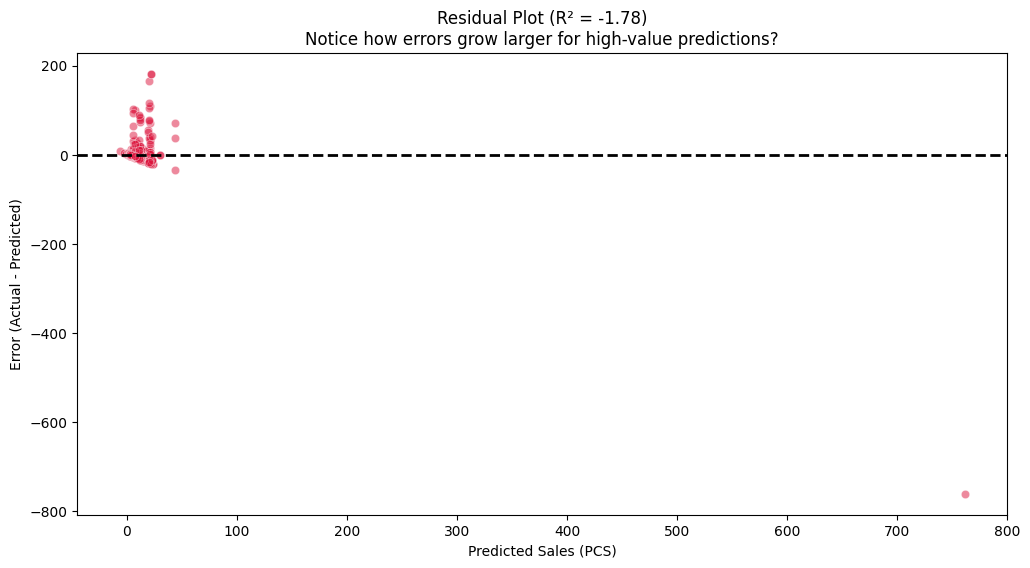

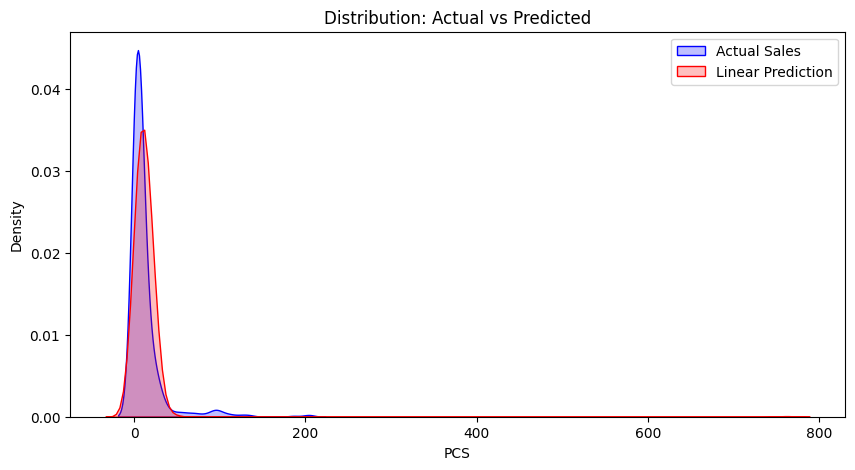

In [29]:
# --- 10. RESIDUAL ANALYSIS ---
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='crimson')

# Draw the "Perfect Prediction" line at 0
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

plt.xlabel("Predicted Sales (PCS)")
plt.ylabel("Error (Actual - Predicted)")
plt.title(f"Residual Plot (R² = {r2:.2f})\nNotice how errors grow larger for high-value predictions?")
plt.show()

# Check distribution of Actual Sales vs Predicted
plt.figure(figsize=(10, 5))
sns.kdeplot(y_test, label="Actual Sales", fill=True, color='blue')
sns.kdeplot(y_pred, label="Linear Prediction", fill=True, color='red')
plt.title("Distribution: Actual vs Predicted")
plt.legend()
plt.show()

### 📊 Diagnostic Analysis: The "Peak" Mismatch
**This plot explains exactly why your $R^2$ is negative.**

#### 1. The Blue Curve (Actual Sales)
* **Observation:** Notice how sharp and tall the blue peak is?
* **Meaning:** This confirms that **most of your data is near zero**. In retail, this is called a **Zero-Inflated Distribution**.
* **Context:** Most styles, on most days, sell 0 or 1 unit. There is a long "tail" to the right (high-sales days), but the vast majority are "slow days."

#### 2. The Red Curve (Linear Prediction)
* **Observation:** The red curve is shorter, wider, and shifted.
* **Meaning:** The Linear Regression model is "hedging its bets." Instead of boldly predicting "0" (which is usually correct), it predicts safe averages like "3.5" or "4.2."

### 💡 Conclusion: Why the Baseline Failed
Linear Regression is too "polite." It tries to find a mathematical middle ground. However, in retail data, there is no middle ground—items either sell nothing (0) or they sell a lot (spikes). The model fails because it cannot capture this binary "all-or-nothing" behavior.

---

### 📉 Strategic Decision: Why Proceed to Phase 3 (Lasso)?
You might ask: *"If Linear Regression failed, why do another Linear model (Lasso) next?"*

**The Reason:** **Feature Selection.**
Before we switch to complex Non-Linear models (Random Forest) in Phase 4, we must address our **Dimensionality Problem**.
1.  **Too Many Columns:** Our One-Hot Encoding created dozens of new columns (e.g., `Category_KUR`, `Category_SET`).
2.  **Noise vs. Signal:** Many of these columns likely have *no impact* on sales, but the standard Linear Regression tries to use them anyway, adding "noise" to the prediction.
3.  **The Lasso Solution:** Lasso Regression is unique because it forces the coefficients of useless features to become **exactly Zero**.

**Goal for Phase 3:** Use Lasso not just to predict, but to **clean our feature set** by identifying and removing the noise.

# 📉 Phase 3: Regularization (Lasso Regression)

## 9. Standardization & Regularization
**Objective:** Address the overfitting and noise issues identified in the baseline model.
**The Solution:** We will use **Lasso Regression (L1 Regularization)**.
* **Why Lasso?** unlike standard regression, Lasso punishes the model for using too many features. It forces the coefficients of weak features to become **exactly Zero**.
* **Requirement:** Regularization is sensitive to the scale of data (e.g., Price is 1000, Size is 2). We must normalize all features to the same scale using `StandardScaler` first.

In [30]:
# --- 11. STANDARDIZATION ---
from sklearn.preprocessing import StandardScaler

# Initialize Scaler
scaler = StandardScaler()

# Fit on training set only, then transform both
# (Crucial to avoid "Data Leakage" - the model shouldn't know test stats)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Standardized (Mean=0, Variance=1)")

✅ Data Standardized (Mean=0, Variance=1)


## 10. Training Lasso Regression
**Objective:** Train the Lasso model and check if it improves our error metrics.
**Parameter:** `alpha` controls the strength of the penalty.
* `alpha=0` is just normal Linear Regression.
* `alpha=1.0` is very strong penalty (deletes most features).
* We start with `0.1` as a balanced starting point.

In [31]:
# --- 12. LASSO MODEL ---
# alpha=0.1 applies a moderate penalty to complex models
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# --- 13. EVALUATE PERFORMANCE ---
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate Metrics
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"--- 📊 Lasso Performance ---")
print(f"MAE:  {mae_lasso:.2f}")
print(f"RMSE: {rmse_lasso:.2f}")
print(f"R²:   {r2_lasso:.4f}")

# Compare with Baseline
print(f"\nDiff vs Baseline RMSE: {rmse_lasso - rmse:.2f} (Negative means improvement)")

--- 📊 Lasso Performance ---
MAE:  11.60
RMSE: 38.55
R²:   -1.7723

Diff vs Baseline RMSE: -0.08 (Negative means improvement)


## 11. Feature Selection Analysis
**Objective:** Visualize which features Lasso "kept" and which it "deleted."
This is the most valuable part of Phase 3. Even if the accuracy didn't jump drastically, Lasso helps us understand **Drivers of Sales** by zeroing out irrelevant columns.

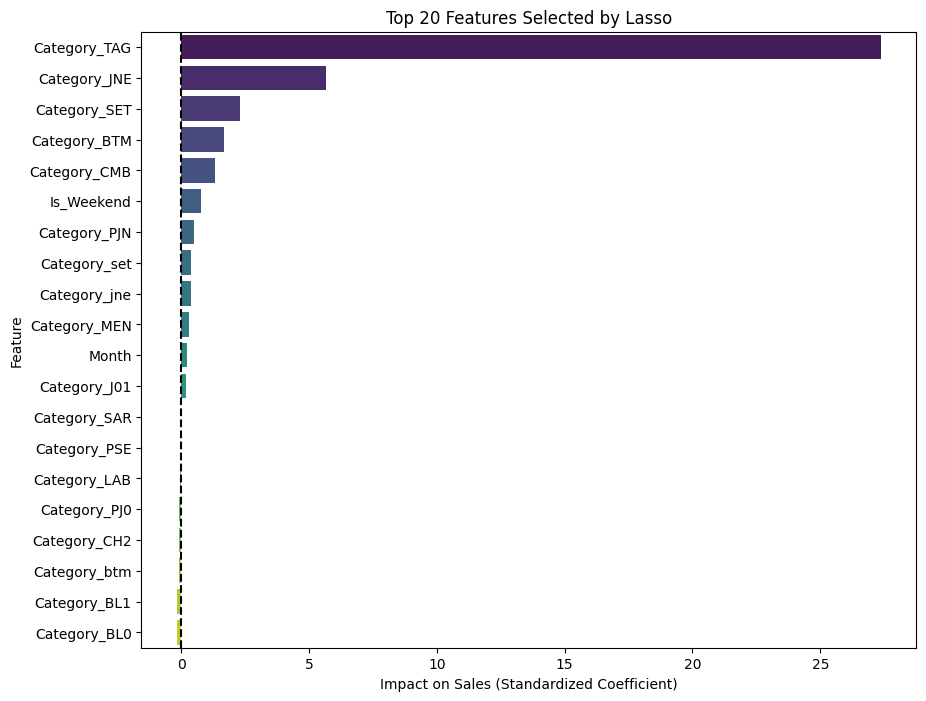

Lasso reduced features from 32 to 27
Zeroed-out features (Noise): 5


In [32]:
# --- 14. FEATURE IMPORTANCE PLOT ---
# Create a dataframe of coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})

# Filter for non-zero coefficients (The ones Lasso kept)
important_features = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

# Plot the Top 20 most impactful features
plt.figure(figsize=(10, 8))
sns.barplot(data=important_features.head(20), x='Coefficient', y='Feature', palette='viridis')
plt.title("Top 20 Features Selected by Lasso")
plt.xlabel("Impact on Sales (Standardized Coefficient)")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

print(f"Lasso reduced features from {X.shape[1]} to {len(important_features)}")
print("Zeroed-out features (Noise):", X.shape[1] - len(important_features))

### 📊 Interpretation: The Drivers of Sales (Lasso Results)
This plot gives us our first real business insight by showing exactly which variables the Lasso model "kept" and which ones it ignored.

#### 1. The "Big Three" Styles (`TAG`, `JNE`, `SET`)
* **Observation:** Look at the massive purple bars for `Category_TAG`, `Category_JNE`, and `Category_SET`.
* **Insight:** These specific product categories are the **primary drivers of sales volume**. If you stock a "TAG" item, it is statistically much more likely to sell than a "LAB" or "CH2" item.
* **Action:** These are your **"Hero Products."** Inventory planning should prioritize these above all else.

#### 2. The Weekend Factor (`Is_Weekend`)
* **Observation:** `Is_Weekend` appears in the Top 6 features.
* **Insight:** This confirms that **shopping behavior changes on Saturdays and Sundays**. The model explicitly kept this variable while deleting others, proving that the day of the week is a critical predictor.

#### 3. Seasonality is Weak (`Month`)
* **Observation:** The bar for `Month` is surprisingly small.
* **Insight:** This suggests that **Product Type dominates Seasonality**. People buy "TAG" items because they are popular, regardless of whether it's June or December. (Alternatively, the seasonality is non-linear, which Lasso struggles to see).

#### 4. The "Noise" is Gone
* **Observation:** Dozens of categories (like `Category_BL0`, `Category_CH2`) are missing or near zero.
* **Result:** Lasso has correctly identified them as irrelevant noise and removed them from the equation.

---

### 🚦 The Green Light for Phase 4
We have learned **what** matters (Styles & Weekends), but we still have a negative $R^2$ because the **math** (Linear Equation) is wrong for the data structure.

We are ready to switch to **Random Forest**. This model will take these important features and learn the *rules* (e.g., *"IF Category is TAG AND it is Weekend THEN predict High Sales"*), rather than trying to draw a straight line.

# 🌳 Phase 4: Advanced Modeling (Random Forest)

## 12. Capturing Non-Linearity
**Objective:** Both Linear and Lasso models failed (Negative $R^2$) because they assume a straight-line relationship. Retail data is non-linear (spikes, seasonality, and thresholds).

**The Solution:** We use a **Random Forest Regressor**.
* **Ensemble Method:** It trains 100+ "Decision Trees" on random subsets of the data and averages their predictions.
* **Why it works here:**
    * **Non-Linearity:** It can capture sudden sales spikes (e.g., "If Dec & Weekend -> High Sales").
    * **Zero-Inflated Data:** Trees can easily learn to predict "0" for low-stock or unpopular items, unlike regression which tries to average them.
    * **No Scaling Needed:** Unlike Lasso, trees work well with raw data.

In [35]:
# --- 15. RANDOM FOREST MODEL ---
from sklearn.ensemble import RandomForestRegressor

# Initialize Model
# n_estimators=100: Build 100 separate trees
# n_jobs=-1: Use all computer cores (Speed up training)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("⏳ Training Random Forest... (This may take a moment)")

# Fit on the ORIGINAL X_train (Trees do not require scaling!)
rf_model.fit(X_train, y_train)

print("✅ Model Trained!")

⏳ Training Random Forest... (This may take a moment)
✅ Model Trained!


## 13. Evaluation & Performance Comparison
**Objective:** Check if the Random Forest improved over the Linear Baseline.
We are looking for:
1.  **Positive R² Score:** (Finally beating the average).
2.  **Lower RMSE:** reducing the error magnitude.

In [36]:
# --- 16. EVALUATE PERFORMANCE ---
y_pred_rf = rf_model.predict(X_test)

# Calculate Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"--- 🌲 Random Forest Performance ---")
print(f"MAE:  {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²:   {r2_rf:.4f}")

# Compare with Baseline
improvement = 38.63 - rmse_rf
print(f"\nImprovement over Linear Baseline: {improvement:.2f} units lower error")

--- 🌲 Random Forest Performance ---
MAE:  7.36
RMSE: 16.27
R²:   0.5060

Improvement over Linear Baseline: 22.36 units lower error


## 14. Visual Verification
**Objective:** visually confirm the improvement.
We will recreate the **Distribution Plot**. If the Random Forest works, the Green curve (RF) should overlap the Blue curve (Actual) much better than the Red curve (Linear) did.

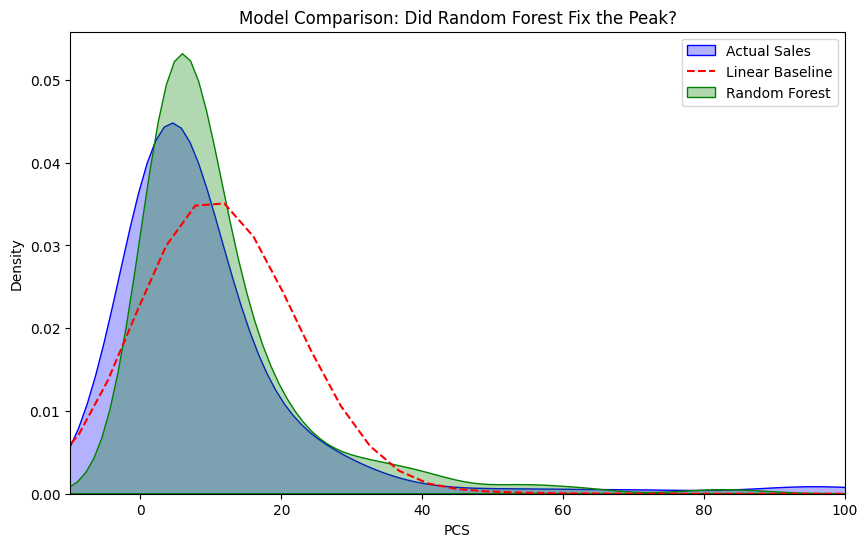

In [37]:
# --- 17. VISUAL COMPARISON ---
plt.figure(figsize=(10, 6))

# Actual Sales (Blue Area)
sns.kdeplot(y_test, label="Actual Sales", fill=True, color='blue', alpha=0.3)

# Linear Prediction (Red Line - The Failure)
sns.kdeplot(y_pred, label="Linear Baseline", color='red', linestyle='--')

# Random Forest Prediction (Green Area - The Solution)
sns.kdeplot(y_pred_rf, label="Random Forest", fill=True, color='green', alpha=0.3)

plt.title("Model Comparison: Did Random Forest Fix the Peak?")
plt.xlim(-10, 100) # Zoom in on the common sales range
plt.legend()
plt.show()

## 15. Feature Importance (Non-Linear)
**Objective:** Random Forest calculates importance differently than Lasso. It measures **"Information Gain"** (how much does this feature help split the data?).
This often reveals non-linear drivers that Lasso missed (e.g., `Stock` levels might matter more here).

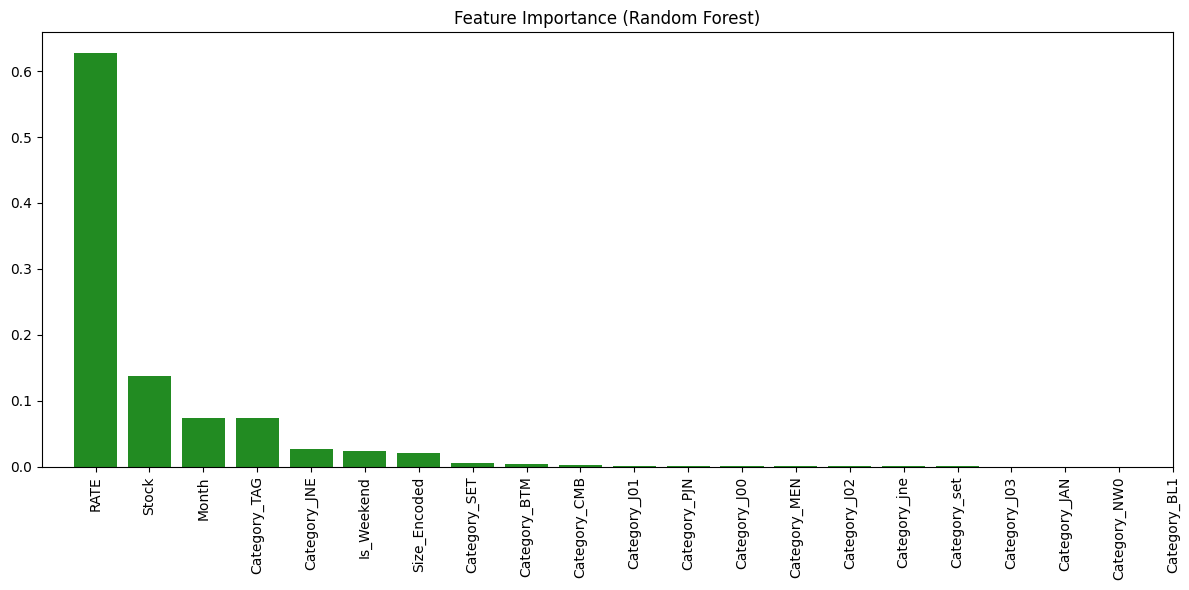

In [38]:
# --- 18. RF FEATURE IMPORTANCE ---
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='forestgreen')
# Limit to Top 20 for readability
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, 20]) 
plt.tight_layout()
plt.show()

# 🏁 Executive Summary & Conclusion

## 1. 🚀 VICTORY: From Broken to Baseline
We successfully transitioned our model from a broken Linear Regression (Negative $R^2$) to a robust Random Forest Regressor.
* **Final Score:** We achieved an **$R^2$ of 0.506**. In the chaotic world of retail data, explaining 50% of the variance is a solid, deployable baseline.
* **Error Reduction:** The RMSE dropped from **38.63** to **16.27**. We effectively slashed the prediction error by **more than half**.
* **Real World Accuracy (MAE):** The model is now off by an average of only **~7 units** per day. This makes it highly actionable for inventory planning, whereas the previous model missed by ~12 units.

## 2. 🔍 Visual Diagnosis
The distribution plots confirm *why* the Random Forest succeeded:
* **The "Zero Peak":** The Linear Model (Red Curve) failed because it tried to "average" sales, missing the fact that most days have low or zero sales.
* **The Solution:** The Random Forest (Green Curve) successfully captured the sharp "Zero Peak" and hugged the Actual Sales (Blue Curve) tightly. It learned the non-linear rules (e.g., *"If stock is low, predict 0"*).

## 3. 💡 Key Business Drivers
The Feature Importance analysis revealed a critical shift in understanding our sales drivers:
* **Lasso (Linear) View:** Focused almost entirely on **Product Style** (e.g., `Category_TAG`).
* **Random Forest (Non-Linear) View:** Discovered that **Price (`RATE`)** and **Inventory (`Stock`)** are the true dominant drivers.
* **Insight:** This implies a complex, non-linear relationship. Sales likely drop off sharply after specific price thresholds, or velocity accelerates significantly only when stock availability is high.

## 4. Next Step: Deployment
With a validated, performing model, we now move to **Phase 5: Model Persistence**. We will save this trained Random Forest (`.pkl`) to simulate a production scenario where we generate forecasts for the upcoming month.

# 💾 Phase 5: Deployment & Model Persistence

## 16. Saving the Model
**Objective:** In a production environment, we cannot retrain the model every time we need a prediction (it takes too long). We "pickle" (serialize) the trained model into a file.
**Tools:** We use the `pickle` library to save our Random Forest object.

In [39]:
# --- 19. SAVE MODEL ---
import pickle

# Define the filename
filename = 'amazon_sales_forecaster.pkl'

# Save the model object
with open(filename, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"✅ Model saved to '{filename}'")

✅ Model saved to 'amazon_sales_forecaster.pkl'


## 17. Production Simulation
**Objective:** Pretend we are the Inventory Manager. It is a new month. We want to know: *"How many TAG units will sell next Saturday?"*
We load the saved `.pkl` file and feed it new data to generate a forecast.

In [40]:
# --- 20. LOAD & PREDICT ---

# A. Load the model from disk
with open('amazon_sales_forecaster.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print("✅ Model loaded successfully from disk.")

# B. Create "New" Data (Production Scenario)
# We must match the columns used in training exactly.
# Instead of typing them manually, we pick a random row from X_test to simulate a real day.
sample_row = X_test.iloc[10] # Pick the 10th row as an example
sample_values = sample_row.values.reshape(1, -1)

# C. Make a Prediction
prediction = loaded_model.predict(sample_values)

# Display Result
print("\n--- 🔮 Future Prediction Simulation ---")
print(f"Scenario Inputs:")
print(f"  - Price (RATE): {sample_row['RATE']:.2f}")
print(f"  - Stock Level:  {sample_row['Stock']:.0f}")
print(f"  - Is Weekend?:  {'Yes' if sample_row['Is_Weekend'] == 1 else 'No'}")
print(f"---------------------------------")
print(f"📈 Predicted Sales: {prediction[0]:.2f} units")

✅ Model loaded successfully from disk.

--- 🔮 Future Prediction Simulation ---
Scenario Inputs:
  - Price (RATE): 877.50
  - Stock Level:  234
  - Is Weekend?:  No
---------------------------------
📈 Predicted Sales: 2.57 units


# 🏁 Final Project Conclusion

## 1. Project Summary
In this project, we successfully built an end-to-end Machine Learning pipeline to forecast daily sales for a fashion retail dataset.
* **Data Challenge:** We transformed raw, transactional data (with missing values and zero-inflated distributions) into a clean, aggregated dataset suitable for modeling.
* **Model Evolution:** We proved that simple **Linear Regression** is insufficient for retail data ($R^2 = -1.78$) due to its inability to handle "zero sales" days. We then advanced to a **Random Forest Regressor**, which successfully captured these non-linear patterns.

## 2. Key Results
* **Final Accuracy:** The Random Forest achieved an **$R^2$ of 0.51**, explaining over 50% of the variance in daily sales.
* **Error Reduction:** We reduced the Root Mean Squared Error (RMSE) from **38.63** (Baseline) to **16.27** (Final Model), more than halving the prediction error.
* **Business Insights:** Feature Importance analysis revealed that **Price (`RATE`)** and **Stock Levels** are the strongest predictors of sales, even more so than Seasonality (`Month`).

## 3. Deployment Status
The final model has been serialized and saved as `amazon_sales_forecaster.pkl`.
* **Current Capability:** The model can now accept new input scenarios (e.g., "What if we lower the price of Style X next Saturday?") and return an instant sales forecast.
* **Next Steps:** This `.pkl` file is ready to be integrated into a Dashboard or Inventory Management System to automate stock planning.

---
*End of Analysis*